In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import sklearn

#建立與 MySQL 的連結
class mysql_engine():
 def __init__(self,db):
  self.user='root'
  self.passwd='ian1991'
  self.host='localhost'
  self.port = '3306'
  self.db_name= db
  self.engine = create_engine('mysql+pymysql://{0}:{1}@{2}:{3}/{4}?charset=utf8'.format(self.user,self.passwd,self.host,self.port,self.db_name))

def get_data(sql,db):
 pg_enine = mysql_engine(db)
 try:
  with pg_enine.engine.connect() as con, con.begin():
   df = pd.read_sql(sql,con) # 獲取資料
  con.close()
 except:
  df = None
 return df

In [2]:
company_factor = get_data("""SELECT * FROM tfb103d_project.datamining_alldata_afetl;""",'tfb103d_project')
company_factor

,stock_code,stock_report_date,operating_gross_rate,net_profit_rate,revenue_growth_rate,current_rate,quick_rate,debt_rate,receivables_turnover_rate,cash_reinvest_rate,...,export_usd_value_37071000,export_usd_value_37079090,export_usd_value_37050000306,export_usd_value_848620,export_usd_value_848610,export_usd_value_381800,new_cases_smoothed_USA,new_cases_smoothed_OWID_EUR,new_cases_smoothed_TWN,people_fully_vaccinated_per_hundred_USA
0,2302,20183,38.03,13.35,17.77,154.53,103.70,18.22,3.31,1.74,...,433,15698,18323,61504,3021,107270,0.00,0.00,0.00,0.00
1,2302,20184,40.93,5.22,-0.91,166.92,110.41,16.86,4.35,1.34,...,395,17864,27973,93168,2669,112119,0.00,0.00,0.00,0.00
2,2302,20191,37.03,-3.00,-6.33,171.94,109.89,16.38,0.99,1.51,...,309,16779,17192,72410,4024,96978,0.00,0.00,0.00,0.00
3,2302,20192,32.10,10.26,-2.46,174.72,114.79,16.63,2.00,2.17,...,326,19927,19788,77517,3432,98799,0.00,0.00,0.00,0.00
4,2302,20193,28.78,2.29,-6.54,170.04,116.92,17.45,3.10,4.32,...,339,20499,19911,118643,3547,90681,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1783,8299,20202,24.76,10.91,10.95,299.48,181.73,27.74,4.28,6.49,...,474,20831,23548,83758,1824,93532,26218.70,22066.62,4.34,0.00
1784,8299,20203,22.61,15.41,-3.71,363.99,240.63,23.66,6.20,5.25,...,362,21623,21166,88039,509,96949,50018.10,27565.47,4.07,0.00
1785,8299,20204,23.05,29.47,-2.52,317.33,230.20,26.09,8.12,11.28,...,338,22734,26507,125111,2209,104276,134753.31,197678.98,7.04,0.29
1786,8299,20211,29.71,13.09,0.17,281.91,191.93,29.32,1.95,-3.70,...,295,21578,21595,173860,3284,108639,120178.33,179397.16,6.49,15.95


# 以財務數據預測 毛利率

資料前處理

In [3]:
#取得需要的特徵
financial_ratio = company_factor[['stock_code',
                                  'stock_report_date',
                                  'net_profit_rate', #稅後淨利率
                                  'operating_gross_rate', #營業毛利率
                                  'current_rate', #流動比率
                                  'quick_rate',  #速動比率
                                  'debt_rate',  #負債比率
                                  'receivables_turnover_rate', #應收帳款週轉率
#                                   'inventory_turnover_rate',  #存貨週轉率
                                  'cash_reinvest_rate', #現金再投資比率
                                  'roe_rate', #股東權益報酬率,
                                  'roa_rate', #資產報酬率
                                  'avg_director_rate', #董監事持股比利
                                  'avg_director_pledge_rate', #董監事質押比利
                                  'foreign_rate_bys', #外資持股比例
                                  'over1000_rate_bys', # >1000張大股東持股比率
                                  'under400_rate_bys', # <400張股東持股比率
                                  'avg_board_bys' #平均持股張數
                                 ]].copy() 
financial_ratio

,stock_code,stock_report_date,net_profit_rate,operating_gross_rate,current_rate,quick_rate,debt_rate,receivables_turnover_rate,cash_reinvest_rate,roe_rate,roa_rate,avg_director_rate,avg_director_pledge_rate,foreign_rate_bys,over1000_rate_bys,under400_rate_bys,avg_board_bys
0,2302,20183,13.35,38.03,154.53,103.70,18.22,3.31,1.74,1.07,0.91,26.60,0.00,4.40,62.23,33.99,8.73
1,2302,20184,5.22,40.93,166.92,110.41,16.86,4.35,1.34,0.42,0.37,26.60,0.00,4.40,62.35,34.08,8.86
2,2302,20191,-3.00,37.03,171.94,109.89,16.38,0.99,1.51,-0.20,-0.14,26.60,0.00,4.37,62.53,33.68,8.90
3,2302,20192,10.26,32.10,174.72,114.79,16.63,2.00,2.17,0.85,0.74,26.60,0.00,4.30,62.34,33.51,9.01
4,2302,20193,2.29,28.78,170.04,116.92,17.45,3.10,4.32,0.17,0.17,26.60,0.00,4.30,62.33,33.44,9.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1783,8299,20202,10.91,24.76,299.48,181.73,27.74,4.28,6.49,4.01,2.97,17.70,12.73,51.13,41.64,44.76,7.51
1784,8299,20203,15.41,22.61,363.99,240.63,23.66,6.20,5.25,6.07,4.61,18.23,17.90,45.53,37.24,51.68,6.58
1785,8299,20204,29.47,23.05,317.33,230.20,26.09,8.12,11.28,11.76,8.79,18.40,17.80,47.07,36.67,51.03,6.80
1786,8299,20211,13.09,29.71,281.91,191.93,29.32,1.95,-3.70,4.71,3.41,18.40,17.80,48.57,38.56,47.51,6.82


In [4]:
#缺值檢視
financial_ratio.isnull().sum()

stock_code                   0
stock_report_date            0
net_profit_rate              0
operating_gross_rate         0
current_rate                 0
quick_rate                   0
debt_rate                    0
receivables_turnover_rate    0
cash_reinvest_rate           0
roe_rate                     0
roa_rate                     0
avg_director_rate            0
avg_director_pledge_rate     0
foreign_rate_bys             0
over1000_rate_bys            0
under400_rate_bys            0
avg_board_bys                0
dtype: int64

In [5]:
# 將數值轉為 1,0 編碼，作為模型的預測目標(應變數)
def encoding(r,th):
    if r >= th:
        return 1
    else:
        return 0

In [6]:
#定義毛利率 >平均者為表現良好
m0 = financial_ratio['operating_gross_rate'].mean()
financial_ratio['operating_gross_rate1'] = financial_ratio.apply(lambda r : encoding(r['operating_gross_rate'],m0), axis = 1)

#定義淨利率 >平均者為表現良好
m1 = financial_ratio['net_profit_rate'].mean()
financial_ratio['net_profit_rate1'] = financial_ratio.apply(lambda r : encoding(r['net_profit_rate'],m1), axis = 1)

#定義股東權益報酬率 >平均者為表現良好
m2 = financial_ratio['roe_rate'].mean()
financial_ratio['roe_rate1'] = financial_ratio.apply(lambda r : encoding(r['roe_rate'],m2), axis = 1)

In [7]:
X = financial_ratio[['current_rate', 'quick_rate', 'debt_rate', 'receivables_turnover_rate', 
                     'cash_reinvest_rate','avg_director_rate', 
                     'avg_director_pledge_rate','foreign_rate_bys','over1000_rate_bys',
                     'under400_rate_bys','avg_board_bys']]
X1 = financial_ratio[['current_rate', 'quick_rate', 'debt_rate', 'receivables_turnover_rate', 
                      'cash_reinvest_rate','avg_director_rate',
                      'avg_director_pledge_rate','foreign_rate_bys','over1000_rate_bys',
                      'under400_rate_bys','avg_board_bys','operating_gross_rate']]
y = financial_ratio['operating_gross_rate1']
y1 = financial_ratio['net_profit_rate1']
y2 = financial_ratio['roe_rate1']
print("y.shape: " ,y.shape)
print('y.sum():',y.sum())
print("y1.shape: " ,y1.shape)
print('y1.sum():',y1.sum())
print("y2.shape: " ,y2.shape)
print('y2.sum():',y2.sum())

y.shape:  (1788,)
y.sum(): 955
y1.shape:  (1788,)
y1.sum(): 1261
y2.shape:  (1788,)
y2.sum(): 960


<h3>毛利率: 833 筆標記為 0 ； 955 筆為 1
<h3>淨利率: 527 筆標記為 0 ； 1261 筆為 1
<h3>ROE:  828 筆標記為 0 ； 960 筆為 1

In [8]:
# 輸入數據調成標準值以免各特徵影響不同
# you'll learn why scaling is needed in a later course
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

scaler1 = StandardScaler()
X1_scaled = scaler1.fit_transform(X)

In [10]:
#分割資料為 測試集 與 訓練集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2,random_state=1)
N, D = X_train.shape
print ("N:", N, "D:", D)

N: 1430 D: 11


<h2> 1-1 以 DNN 類神經網路 實作 - 預測毛利率

In [14]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout,LeakyReLU
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix

In [12]:
# 建立TF模型
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(D,)),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.6),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid'),
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               6144      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

In [14]:
#編譯模型
lr = 0.0002
model.compile(tf.keras.optimizers.Adam(learning_rate = lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [15]:
# 訓練模型
r = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200)

# 評估模型 - evaluate() returns loss and accuracy
print("=====================================================================")
print("Train score:", model.evaluate(X_train, y_train))

print("Test score:", model.evaluate(X_test, y_test))

Epoch 1/200
45/45 [==============================] - 2s 18ms/step - loss: 0.6836 - accuracy: 0.5427 - val_loss: 0.6648 - val_accuracy: 0.6369
Epoch 2/200
45/45 [==============================] - 0s 5ms/step - loss: 0.6645 - accuracy: 0.5895 - val_loss: 0.6474 - val_accuracy: 0.6676
Epoch 3/200
45/45 [==============================] - 0s 6ms/step - loss: 0.6559 - accuracy: 0.6091 - val_loss: 0.6239 - val_accuracy: 0.6872
Epoch 4/200
45/45 [==============================] - 0s 8ms/step - loss: 0.6392 - accuracy: 0.6266 - val_loss: 0.6098 - val_accuracy: 0.6872
Epoch 5/200
45/45 [==============================] - 0s 10ms/step - loss: 0.6348 - accuracy: 0.6371 - val_loss: 0.5971 - val_accuracy: 0.7011
Epoch 6/200
45/45 [==============================] - 0s 10ms/step - loss: 0.6323 - accuracy: 0.6378 - val_loss: 0.5885 - val_accuracy: 0.7095
Epoch 7/200
45/45 [==============================] - 0s 10ms/step - loss: 0.6269 - accuracy: 0.6336 - val_loss: 0.5843 - val_accuracy: 0.7095
Epoch 8/2

Epoch 59/200
45/45 [==============================] - 0s 8ms/step - loss: 0.5326 - accuracy: 0.6951 - val_loss: 0.5067 - val_accuracy: 0.7542
Epoch 60/200
45/45 [==============================] - 0s 8ms/step - loss: 0.5316 - accuracy: 0.7049 - val_loss: 0.5027 - val_accuracy: 0.7514
Epoch 61/200
45/45 [==============================] - 0s 8ms/step - loss: 0.5405 - accuracy: 0.7042 - val_loss: 0.5069 - val_accuracy: 0.7486
Epoch 62/200
45/45 [==============================] - 0s 8ms/step - loss: 0.5405 - accuracy: 0.7063 - val_loss: 0.5021 - val_accuracy: 0.7570
Epoch 63/200
45/45 [==============================] - 0s 5ms/step - loss: 0.5301 - accuracy: 0.7189 - val_loss: 0.5000 - val_accuracy: 0.7654
Epoch 64/200
45/45 [==============================] - 0s 5ms/step - loss: 0.5345 - accuracy: 0.7049 - val_loss: 0.5004 - val_accuracy: 0.7598
Epoch 65/200
45/45 [==============================] - 0s 5ms/step - loss: 0.5349 - accuracy: 0.7196 - val_loss: 0.4959 - val_accuracy: 0.7654
Epoch 

45/45 [==============================] - 0s 4ms/step - loss: 0.4097 - accuracy: 0.8014 - val_loss: 0.3965 - val_accuracy: 0.8073
Epoch 174/200
45/45 [==============================] - 0s 4ms/step - loss: 0.4215 - accuracy: 0.7965 - val_loss: 0.3960 - val_accuracy: 0.8045
Epoch 175/200
45/45 [==============================] - 0s 4ms/step - loss: 0.4277 - accuracy: 0.7965 - val_loss: 0.3976 - val_accuracy: 0.7989
Epoch 176/200
45/45 [==============================] - 0s 4ms/step - loss: 0.4281 - accuracy: 0.7979 - val_loss: 0.3966 - val_accuracy: 0.8017
Epoch 177/200
45/45 [==============================] - 0s 4ms/step - loss: 0.4287 - accuracy: 0.7951 - val_loss: 0.3959 - val_accuracy: 0.8073
Epoch 178/200
45/45 [==============================] - 0s 4ms/step - loss: 0.4174 - accuracy: 0.8028 - val_loss: 0.3968 - val_accuracy: 0.8045
Epoch 179/200
45/45 [==============================] - 0s 3ms/step - loss: 0.4286 - accuracy: 0.7881 - val_loss: 0.3967 - val_accuracy: 0.8073
Epoch 180/200

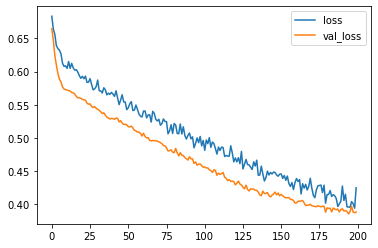

In [16]:
# 劃出 model.fit() training 和 validating 的 loss
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

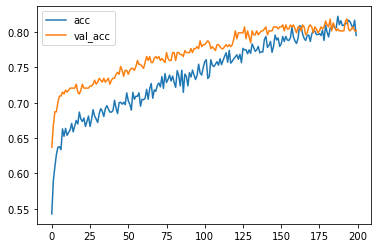

In [17]:
# 劃出準確性 accuracy 
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [18]:
pred_test = model.predict(X_test)
pred_test = np.round(pred_test).flatten()
cm = confusion_matrix(y_test, pred_test)
cm

array([[136,  43],
       [ 28, 151]], dtype=int64)

<h1> 1-2 以羅吉斯回歸實作 - 預測毛利率

In [19]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression()
log.fit(X_train, y_train)

log_pred = log.predict(X_test)
print(log_pred)
print("==============================")
print(log.score(X_train, y_train))
# print(y_test)

[0 1 1 1 1 1 0 1 0 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0
 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 0 0 1 1 0 0 0 1 1 0
 0 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 0 1 0 1 1 0 0 1 0 0 1 1 1 1 0
 0 0 1 1 1 1 0 0 0 1 1 0 1 1 0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 0 0 1 1 1 1 0 0
 0 0 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 0 1
 0 1 1 0 1 0 0 1 0 0 0 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1
 0 1 1 0 0 0 1 0 0 1 0 1 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 1 0 1 0 1 0 1 1 1 0
 0 1 0 0 0 0 0 1 0 0 1 0 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1 0
 0 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 0 1 0 0 1 1 1 1 0]
0.6804195804195804


In [20]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, log_pred)
accuracy

0.7122905027932961

In [21]:
cm = confusion_matrix(y_test, log_pred)
cm

array([[114,  65],
       [ 38, 141]], dtype=int64)

<h2> 1-3 以 SVM 實作 - 預測毛利率

In [ ]:
from sklearn.svm import SVC
clf = SVC(C = 1e5, kernel = 'linear')
clf.fit(X_train, y_train) 

In [ ]:
pred_clf = clf.predict(X_test)
print(pred_clf)
print("==============================")
print(clf.score(X_train, y_train))

In [ ]:
accuracy_SVM = accuracy_score(y_test, pred_clf)
accuracy_SVM

<h1>1.4 以 RandomForestClassifier 實作 毛利率預測

In [22]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
forest=RandomForestClassifier(n_estimators=100)


#Train the model using the training sets y_pred=clf.predict(X_test)
forest.fit(X_train, y_train)
print(forest.score(X_train, y_train))

1.0


In [23]:
from sklearn.metrics import accuracy_score
forest_pred=forest.predict(X_test)
print("Accuracy:",accuracy_score(y_test, forest_pred))

Accuracy: 0.8743016759776536


In [24]:
pred_test = np.round(forest_pred).flatten()
cm = confusion_matrix(y_test, pred_test)
cm

array([[149,  30],
       [ 15, 164]], dtype=int64)

<h1> 1.5 以 naive_bayes 實作 毛利率預測

In [25]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)
print(nb.score(X_train, y_train))

0.6258741258741258


In [26]:
nb_pred = nb.predict(X_test)
print("Accuracy:",accuracy_score(y_test, nb_pred))

Accuracy: 0.6536312849162011


In [27]:
pred_test = np.round(nb_pred).flatten()
cm = confusion_matrix(y_test, pred_test)
cm

array([[111,  68],
       [ 56, 123]], dtype=int64)

<h1> 1.6 以 KNN 實作 毛利率預測

In [28]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print(knn.score(X_train, y_train))

0.8748251748251749


In [29]:
knn_pred = knn.predict(X_test)
print("Accuracy:",accuracy_score(y_test, knn_pred))

Accuracy: 0.7932960893854749


In [30]:
pred_test = np.round(knn_pred).flatten()
cm = confusion_matrix(y_test, pred_test)
cm

array([[144,  35],
       [ 39, 140]], dtype=int64)

<h2>初步測試預測"毛利率"結果:</h2>
<h4>1-1 DNN: 
    <h4>測試資料集準確度 0.8779; 訓練資料準確度 0.7836</h4>
<h4>1-2 Logistic:
    <h4>測試資料集準確度 0.7204; 訓練資料準確度 0.6648</h4>
<h4>1-3 SVM: 
    <h4>測試資料集準確度 0.5316; 訓練資料準確度 0.5068</h4>
<h4>1-4 RandomForestClassifier: 
    <h4>測試資料集準確度 1.0000; 訓練資料準確度 0.8366</h4>
<h4>1-5 naive_bayes: 
    <h4>測試資料集準確度 0.5275; 訓練資料準確度 0.4930</h4>
<h4>1-6 KNN: 
    <h4>測試資料集準確度 0.6944; 訓練資料準確度 0.4676</h4>

<h3>目前"毛利率"表現最佳者為 RandomForestClassifier，DNN 其次

<h3>_____________________分隔_______________________

# 以財務數據預測 淨利率

<h2> 2-1 以 DNN 實作預測 淨利率

In [31]:
X_train, X_test, y1_train, y1_test = train_test_split(X_scaled, y1, test_size=0.2)
N, D = X_train.shape
print ("N:", N, "D:", D)

N: 1430 D: 11


In [32]:
# 建立TF模型 for 淨利
model1 = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(D,)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
  ])

#編譯模型
lr = 0.0003
model1.compile(tf.keras.optimizers.Adam(learning_rate = lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [33]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                768       
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


In [34]:
# 訓練模型
r1 = model1.fit(X_train, y1_train, validation_data=(X_test, y1_test), epochs=120)

# 評估模型 - evaluate() returns loss and accuracy
print("Train score:", model1.evaluate(X_train, y1_train))
print("Test score:", model1.evaluate(X_test, y1_test))

Epoch 1/120
45/45 [==============================] - 1s 5ms/step - loss: 0.7400 - accuracy: 0.4573 - val_loss: 0.6953 - val_accuracy: 0.5475
Epoch 2/120
45/45 [==============================] - 0s 1ms/step - loss: 0.6578 - accuracy: 0.6573 - val_loss: 0.6592 - val_accuracy: 0.6564
Epoch 3/120
45/45 [==============================] - 0s 1ms/step - loss: 0.6221 - accuracy: 0.7063 - val_loss: 0.6328 - val_accuracy: 0.6648
Epoch 4/120
45/45 [==============================] - 0s 1ms/step - loss: 0.5957 - accuracy: 0.7210 - val_loss: 0.6103 - val_accuracy: 0.6704
Epoch 5/120
45/45 [==============================] - 0s 1ms/step - loss: 0.5716 - accuracy: 0.7217 - val_loss: 0.5901 - val_accuracy: 0.6648
Epoch 6/120
45/45 [==============================] - 0s 1ms/step - loss: 0.5511 - accuracy: 0.7308 - val_loss: 0.5750 - val_accuracy: 0.6844
Epoch 7/120
45/45 [==============================] - 0s 1ms/step - loss: 0.5441 - accuracy: 0.7336 - val_loss: 0.5629 - val_accuracy: 0.6872
Epoch 8/120
4

Epoch 59/120
45/45 [==============================] - 0s 1ms/step - loss: 0.4403 - accuracy: 0.8028 - val_loss: 0.5035 - val_accuracy: 0.7598
Epoch 60/120
45/45 [==============================] - 0s 1ms/step - loss: 0.4454 - accuracy: 0.7860 - val_loss: 0.5007 - val_accuracy: 0.7598
Epoch 61/120
45/45 [==============================] - 0s 1ms/step - loss: 0.4347 - accuracy: 0.8028 - val_loss: 0.4991 - val_accuracy: 0.7626
Epoch 62/120
45/45 [==============================] - 0s 1ms/step - loss: 0.4420 - accuracy: 0.8035 - val_loss: 0.5021 - val_accuracy: 0.7654
Epoch 63/120
45/45 [==============================] - 0s 1ms/step - loss: 0.4370 - accuracy: 0.7937 - val_loss: 0.5000 - val_accuracy: 0.7598
Epoch 64/120
45/45 [==============================] - 0s 1ms/step - loss: 0.4353 - accuracy: 0.8077 - val_loss: 0.4989 - val_accuracy: 0.7654
Epoch 65/120
45/45 [==============================] - 0s 1ms/step - loss: 0.4271 - accuracy: 0.8084 - val_loss: 0.4994 - val_accuracy: 0.7626
Epoch 

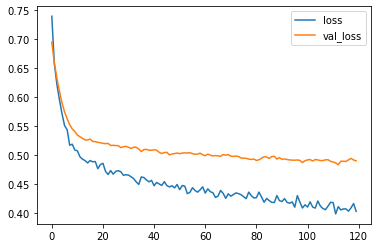

In [35]:
# 劃出 model.fit() training 和 validating 的 loss
import matplotlib.pyplot as plt
plt.plot(r1.history['loss'], label='loss')
plt.plot(r1.history['val_loss'], label='val_loss')
plt.legend()

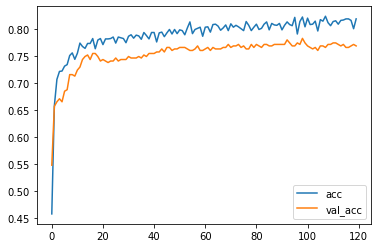

In [36]:
# 劃出準確性 accuracy 
plt.plot(r1.history['accuracy'], label='acc')
plt.plot(r1.history['val_accuracy'], label='val_acc')
plt.legend()

In [45]:
model.save('./net_profit_model.h5')

<h1> 2-2 用羅吉斯回歸實作 預測淨利率

In [37]:
from sklearn.linear_model import LogisticRegression
log1 = LogisticRegression()
log1.fit(X_train, y1_train)

pred1 = log1.predict(X_test)
print(pred1)
print("==============================")
print(log1.score(X_train, y1_train))
# print(y_test)

[1 0 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1 1
 1 1 0 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0
 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.7657342657342657


In [38]:
accuracy1 = accuracy_score(y1_test, pred1)
accuracy1

0.729050279329609

<h1> 2-3 以 SVM 實作 預測淨利率

In [ ]:
from sklearn.svm import SVC
clf1 = SVC(C = 1e5, kernel = 'linear')
clf1.fit(X_train, y1_train) 
pred_clf1 = clf1.predict(X_test)
print(pred_clf1)
print("==============================")
print(clf1.score(X_train, y1_train))

In [ ]:
accuracy_SVM = accuracy_score(y1_test, pred_clf1)
accuracy_SVM

<h1>2.4 以 RandomForestClassifier 實作 淨利率 預測

In [39]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
forest1=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
forest1.fit(X_train, y1_train)
print(forest1.score(X_train, y1_train))

1.0


In [40]:
from sklearn.metrics import accuracy_score
forest_pred1=forest1.predict(X_test)
print("Accuracy:",accuracy_score(y1_test, forest_pred1))

Accuracy: 0.8072625698324022


<h1> 2.5 以 naive_bayes 實作 淨利率 預測

In [41]:
from sklearn.naive_bayes import GaussianNB
nb1 = GaussianNB()
nb1.fit(X_train, y1_train)
print(nb1.score(X_train, y1_train))

0.7363636363636363


In [42]:
nb1_pred = nb1.predict(X_test)
print("Accuracy:",accuracy_score(y1_test, nb1_pred))

Accuracy: 0.6759776536312849


<h1> 2.6 以 KNN 實作 淨利率 預測

In [45]:
from sklearn.neighbors import KNeighborsClassifier
knn1 = KNeighborsClassifier()
knn1.fit(X_train, y1_train)
print(knn1.score(X_train, y1_train))

0.8636363636363636


In [46]:
knn1_pred = knn1.predict(X_test)
print("Accuracy:",accuracy_score(y1_test, knn1_pred))

Accuracy: 0.7653631284916201


<h3>初步測試預測"淨利率"結果:</h3>
<h4>1-1 DNN: 
    <h4>測試資料集準確度 0.8237; 訓練資料準確度 0.7753</h4>
<h4>1-2 Logistic:
    <h4>測試資料集準確度 0.7428 ; 訓練資料準確度 0.7726</h4>
<h4>1-3 SVM: 
    <h4>測試資料集準確度 0.7479; 訓練資料準確度 0.7239</h4>
<h4>1-4 RandomForestClassifier: 
    <h4>測試資料集準確度 1.0000; 訓練資料準確度 0.7915</h4>
<h4>1-5 naive_bayes: 
    <h4>測試資料集準確度 0.7246; 訓練資料準確度 0.7211</h4>
<h4>1-6 KNN: 
    <h4>測試資料集準確度 0.8655; 訓練資料準確度 0.8169</h4>

<h3>目前 "淨利率預測" 各演算法表現相近，最佳者為 KNN ，RandomForestClassifier 其次

<h3>_____________________分隔_______________________

# 以財務數據預測 ROE

In [27]:
X1_train, X1_test, y2_train, y2_test = train_test_split(X1_scaled, y2, test_size=0.2,random_state=1)
N, D = X1_train.shape
print ("N:", N, "D:", D)

N: 1430 D: 11


<h2> 3-1 以 DNN 實作預測 ROE

In [38]:
# 建立TF模型 for 淨利
model3 = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(D,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
  ])

#編譯模型
lr = 0.0003
model3.compile(tf.keras.optimizers.Adam(learning_rate = lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [39]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               1536      
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 5,697
Trainable params: 5,697
Non-trainable params: 0
_________________________________________________________________


In [40]:
# 訓練模型
r3 = model3.fit(X1_train, y2_train, validation_data=(X1_test, y2_test), epochs=180)

# 評估模型 - evaluate() returns loss and accuracy
print("Train score:", model3.evaluate(X1_train, y2_train))
print("Test score:", model3.evaluate(X1_test, y2_test))

Epoch 1/180
45/45 [==============================] - 0s 3ms/step - loss: 0.6786 - accuracy: 0.5741 - val_loss: 0.6487 - val_accuracy: 0.6397
Epoch 2/180
45/45 [==============================] - 0s 1ms/step - loss: 0.6533 - accuracy: 0.6077 - val_loss: 0.6232 - val_accuracy: 0.6648
Epoch 3/180
45/45 [==============================] - 0s 1ms/step - loss: 0.6363 - accuracy: 0.6294 - val_loss: 0.6076 - val_accuracy: 0.6788
Epoch 4/180
45/45 [==============================] - 0s 1ms/step - loss: 0.6274 - accuracy: 0.6364 - val_loss: 0.5955 - val_accuracy: 0.6927
Epoch 5/180
45/45 [==============================] - 0s 1ms/step - loss: 0.6158 - accuracy: 0.6650 - val_loss: 0.5887 - val_accuracy: 0.7011
Epoch 6/180
45/45 [==============================] - 0s 1ms/step - loss: 0.6082 - accuracy: 0.6692 - val_loss: 0.5814 - val_accuracy: 0.7123
Epoch 7/180
45/45 [==============================] - 0s 1ms/step - loss: 0.5967 - accuracy: 0.6797 - val_loss: 0.5737 - val_accuracy: 0.7123
Epoch 8/180
4

Epoch 59/180
45/45 [==============================] - 0s 1ms/step - loss: 0.5191 - accuracy: 0.7385 - val_loss: 0.5144 - val_accuracy: 0.7374
Epoch 60/180
45/45 [==============================] - 0s 1ms/step - loss: 0.5302 - accuracy: 0.7413 - val_loss: 0.5151 - val_accuracy: 0.7374
Epoch 61/180
45/45 [==============================] - 0s 1ms/step - loss: 0.5312 - accuracy: 0.7308 - val_loss: 0.5152 - val_accuracy: 0.7346
Epoch 62/180
45/45 [==============================] - 0s 1ms/step - loss: 0.5241 - accuracy: 0.7273 - val_loss: 0.5131 - val_accuracy: 0.7318
Epoch 63/180
45/45 [==============================] - 0s 1ms/step - loss: 0.5300 - accuracy: 0.7294 - val_loss: 0.5145 - val_accuracy: 0.7318
Epoch 64/180
45/45 [==============================] - 0s 1ms/step - loss: 0.5222 - accuracy: 0.7329 - val_loss: 0.5154 - val_accuracy: 0.7318
Epoch 65/180
45/45 [==============================] - 0s 1ms/step - loss: 0.5269 - accuracy: 0.7420 - val_loss: 0.5151 - val_accuracy: 0.7346
Epoch 

45/45 [==============================] - 0s 2ms/step - loss: 0.4841 - accuracy: 0.7629 - val_loss: 0.5046 - val_accuracy: 0.7263
Epoch 117/180
45/45 [==============================] - 0s 1ms/step - loss: 0.4881 - accuracy: 0.7629 - val_loss: 0.5044 - val_accuracy: 0.7346
Epoch 118/180
45/45 [==============================] - 0s 1ms/step - loss: 0.4866 - accuracy: 0.7587 - val_loss: 0.5027 - val_accuracy: 0.7291
Epoch 119/180
45/45 [==============================] - 0s 1ms/step - loss: 0.4812 - accuracy: 0.7629 - val_loss: 0.5033 - val_accuracy: 0.7346
Epoch 120/180
45/45 [==============================] - 0s 1ms/step - loss: 0.4835 - accuracy: 0.7678 - val_loss: 0.5015 - val_accuracy: 0.7318
Epoch 121/180
45/45 [==============================] - 0s 1ms/step - loss: 0.4842 - accuracy: 0.7629 - val_loss: 0.5020 - val_accuracy: 0.7374
Epoch 122/180
45/45 [==============================] - 0s 1ms/step - loss: 0.4911 - accuracy: 0.7510 - val_loss: 0.5032 - val_accuracy: 0.7235
Epoch 123/180

45/45 [==============================] - 0s 2ms/step - loss: 0.4624 - accuracy: 0.7818 - val_loss: 0.5005 - val_accuracy: 0.7374
Epoch 174/180
45/45 [==============================] - 0s 2ms/step - loss: 0.4687 - accuracy: 0.7636 - val_loss: 0.5004 - val_accuracy: 0.7346
Epoch 175/180
45/45 [==============================] - 0s 2ms/step - loss: 0.4772 - accuracy: 0.7517 - val_loss: 0.5006 - val_accuracy: 0.7346
Epoch 176/180
45/45 [==============================] - 0s 2ms/step - loss: 0.4682 - accuracy: 0.7657 - val_loss: 0.5002 - val_accuracy: 0.7291
Epoch 177/180
45/45 [==============================] - 0s 2ms/step - loss: 0.4606 - accuracy: 0.7783 - val_loss: 0.4992 - val_accuracy: 0.7263
Epoch 178/180
45/45 [==============================] - 0s 2ms/step - loss: 0.4644 - accuracy: 0.7692 - val_loss: 0.5007 - val_accuracy: 0.7374
Epoch 179/180
45/45 [==============================] - 0s 2ms/step - loss: 0.4640 - accuracy: 0.7769 - val_loss: 0.4989 - val_accuracy: 0.7430
Epoch 180/180

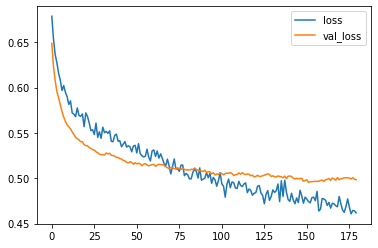

In [41]:
# 劃出 model.fit() training 和 validating 的 loss
import matplotlib.pyplot as plt
plt.plot(r3.history['loss'], label='loss')
plt.plot(r3.history['val_loss'], label='val_loss')
plt.legend()

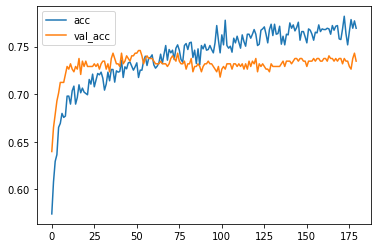

In [42]:
# 劃出準確性 accuracy 
plt.plot(r3.history['accuracy'], label='acc')
plt.plot(r3.history['val_accuracy'], label='val_acc')
plt.legend()

In [43]:
pred_test = model3.predict(X1_test)
pred_test = np.round(pred_test).flatten()
cm = confusion_matrix(y2_test, pred_test)
cm

array([[122,  51],
       [ 44, 141]], dtype=int64)

In [58]:
model3.save('./ROE_model.h5')

<h1> 3-2 用羅吉斯回歸實作 預測 ROE

In [54]:
from sklearn.linear_model import LogisticRegression
log3 = LogisticRegression()
log3.fit(X1_train, y2_train)

pred3 = log3.predict(X1_test)
print(pred3)
print("==============================")
print(log3.score(X1_train, y2_train))
# print(y_test)

[0 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1
 0 0 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 1 1 0 0 0 1 1 1 1 1 1 0 1
 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 1 1
 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 1 0 0 1 1 1 1 0
 0 1 0 0 0 1 0 1 1 1 1 0 0 0 1 1 1 0 1 0 0 1 1 0 1 1 1 0 0 0 1 1 1 0 1 0 1
 1 1 0 1 1 0 0 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 0 0 1 1 0 1 0 0 0 1 0 1
 0 0 1 0 0 1 1 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 0 1 1
 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 0 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1
 0 0 1 1 1 0 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0]
0.727972027972028


In [55]:
accuracy3 = accuracy_score(y2_test, pred3)
accuracy3

0.7094972067039106

<h1> 3-3 以 SVM 實作 預測 ROE

In [ ]:
from sklearn.svm import SVC
clf3 = SVC(C = 1e5, kernel = 'linear')
clf3.fit(X1_train, y2_train) 
pred_clf3 = clf3.predict(X1_test)
print(pred_clf3)
print("==============================")
print(clf3.score(X1_train, y2_train))

In [ ]:
accuracy_SVM = accuracy_score(y2_test, pred_clf3)
accuracy_SVM

<h1>3.4 以 RandomForestClassifier 實作 ROE 預測

In [56]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
forest3=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
forest3.fit(X1_train, y2_train)
print(forest3.score(X1_train, y2_train))

1.0


In [57]:
from sklearn.metrics import accuracy_score
forest_pred3 = forest3.predict(X1_test)
print("Accuracy:",accuracy_score(y2_test, forest_pred3))

Accuracy: 0.7737430167597765


<h1> 3.5 以 naive_bayes 實作 ROE 預測

In [58]:
from sklearn.naive_bayes import GaussianNB
nb3 = GaussianNB()
nb3.fit(X1_train, y2_train)
print(nb3.score(X1_train, y2_train))

0.6447552447552447


In [59]:
nb3_pred = nb3.predict(X1_test)
print("Accuracy:",accuracy_score(y2_test, nb3_pred))

Accuracy: 0.6284916201117319


<h1> 3.6 以 KNN 實作 ROE 預測

In [60]:
from sklearn.neighbors import KNeighborsClassifier
knn3 = KNeighborsClassifier()
knn3.fit(X1_train, y2_train)
print(knn3.score(X1_train, y2_train))

0.8265734265734266


In [61]:
knn3_pred = knn3.predict(X1_test)
print("Accuracy:",accuracy_score(y2_test, knn3_pred))

Accuracy: 0.7625698324022346


<h3>初步測試預測"ROA"結果:</h3>
<h4>1-1 DNN: 
    <h4>測試資料集準確度 0.9979; 訓練資料準確度 0.9915</h4>
<h4>1-2 Logistic:
    <h4>測試資料集準確度 0.9908 ; 訓練資料準確度 0.9887</h4>
<h4>1-3 SVM: 
    <h4>測試資料集準確度 1.0000; 訓練資料準確度 0.9972</h4>
<h4>1-4 RandomForestClassifier: 
    <h4>測試資料集準確度 1.0000; 訓練資料準確度 1.0000</h4>
<h4>1-5 naive_bayes: 
    <h4>測試資料集準確度 0.8654; 訓練資料準確度 0.8676</h4>
<h4>1-6 KNN: 
    <h4>測試資料集準確度 0.9323; 訓練資料準確度 0.8789</h4>

<h3>___________終止線_______________

<h1>加入 輸入

<h2>資料前處理

In [44]:
#取得需要的特徵
dF =  company_factor[['stock_code',
                                  'stock_report_date',
                                  'net_profit_rate', #稅後淨利率
                                  'operating_gross_rate', #營業毛利率
                                  'current_rate', #流動比率
                                  'quick_rate',  #速動比率
                                  'debt_rate',  #負債比率
                                  'receivables_turnover_rate', #應收帳款週轉率
                                  'cash_reinvest_rate', #現金再投資比率
                                  'roe_rate', #股東權益報酬率,
                                  'roa_rate', #資產報酬率
                                  'avg_director_rate', #董監事持股比利
                                  'avg_director_pledge_rate', #董監事質押比利
                                  'foreign_rate_bys', #外資持股比例
                                  'over1000_rate_bys', # >1000張大股東持股比率
                                  'under400_rate_bys', # <400張股東持股比率
                                  'avg_board_bys', #平均持股張數
#                                   'import_kgm_weight_2801', 
#                                   'import_kgm_weight_2804', 
#                                   'import_kgm_weight_37071000',
#                                   'import_kgm_weight_37079090',
#                                   'import_kgm_weight_37050000306',
#                                   'import_kgm_weight_848620',
#                                   'import_kgm_weight_848610',
#                                   'import_kgm_weight_381800',
#                                   'import_usd_value_2801',
#                                   'import_usd_value_2804',
#                                   'import_usd_value_37071000',
#                                   'import_usd_value_37079090',
#                                   'import_usd_value_37050000306',
#                                   'import_usd_value_848620',
#                                   'import_usd_value_848610',
#                                   'import_usd_value_381800',
                                  'avg_import_rate'
                                     ]].copy() 
dF

,stock_code,stock_report_date,net_profit_rate,operating_gross_rate,current_rate,quick_rate,debt_rate,receivables_turnover_rate,cash_reinvest_rate,roe_rate,roa_rate,avg_director_rate,avg_director_pledge_rate,foreign_rate_bys,over1000_rate_bys,under400_rate_bys,avg_board_bys,avg_import_rate
0,2302,20183,13.35,38.03,154.53,103.70,18.22,3.31,1.74,1.07,0.91,26.60,0.00,4.40,62.23,33.99,8.73,30.719
1,2302,20184,5.22,40.93,166.92,110.41,16.86,4.35,1.34,0.42,0.37,26.60,0.00,4.40,62.35,34.08,8.86,30.901
2,2302,20191,-3.00,37.03,171.94,109.89,16.38,0.99,1.51,-0.20,-0.14,26.60,0.00,4.37,62.53,33.68,8.90,30.880
3,2302,20192,10.26,32.10,174.72,114.79,16.63,2.00,2.17,0.85,0.74,26.60,0.00,4.30,62.34,33.51,9.01,31.187
4,2302,20193,2.29,28.78,170.04,116.92,17.45,3.10,4.32,0.17,0.17,26.60,0.00,4.30,62.33,33.44,9.11,31.248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1783,8299,20202,10.91,24.76,299.48,181.73,27.74,4.28,6.49,4.01,2.97,17.70,12.73,51.13,41.64,44.76,7.51,29.941
1784,8299,20203,15.41,22.61,363.99,240.63,23.66,6.20,5.25,6.07,4.61,18.23,17.90,45.53,37.24,51.68,6.58,29.499
1785,8299,20204,29.47,23.05,317.33,230.20,26.09,8.12,11.28,11.76,8.79,18.40,17.80,47.07,36.67,51.03,6.80,28.783
1786,8299,20211,13.09,29.71,281.91,191.93,29.32,1.95,-3.70,4.71,3.41,18.40,17.80,48.57,38.56,47.51,6.82,28.419


In [45]:
dF.isnull().sum()

stock_code                   0
stock_report_date            0
net_profit_rate              0
operating_gross_rate         0
current_rate                 0
quick_rate                   0
debt_rate                    0
receivables_turnover_rate    0
cash_reinvest_rate           0
roe_rate                     0
roa_rate                     0
avg_director_rate            0
avg_director_pledge_rate     0
foreign_rate_bys             0
over1000_rate_bys            0
under400_rate_bys            0
avg_board_bys                0
avg_import_rate              0
dtype: int64

In [46]:
#定義毛利率 >平均者為表現良好
m0 = dF['operating_gross_rate'].mean()
dF['operating_gross_rate1'] = dF.apply(lambda r : encoding(r['operating_gross_rate'],m0), axis = 1)

#定義淨利率 >平均者為表現良好
m1 = dF['net_profit_rate'].mean()
dF['net_profit_rate1'] = dF.apply(lambda r : encoding(r['net_profit_rate'],m1), axis = 1)

#定義股東權益報酬率 >平均者為表現良好
m2 = dF['roe_rate'].mean()
dF['roe_rate1'] = dF.apply(lambda r : encoding(r['roe_rate'],m2), axis = 1)

In [49]:
X = dF[['current_rate', #流動比率
        'quick_rate',  #速動比率
        'debt_rate',  #負債比率
        'receivables_turnover_rate', #應收帳款週轉率
        'cash_reinvest_rate', #現金再投資比率
#         'roe_rate', #股東權益報酬率,
#         'roa_rate', #資產報酬率
        'avg_director_rate', #董監事持股比利
        'avg_director_pledge_rate', #董監事質押比利
        'foreign_rate_bys', #外資持股比例
        'over1000_rate_bys', # >1000張大股東持股比率
        'under400_rate_bys', # <400張股東持股比率
        'avg_board_bys', #平均持股張數
#         'import_kgm_weight_2801', 
#         'import_kgm_weight_2804', 
#         'import_kgm_weight_37071000',
#         'import_kgm_weight_37079090',
#         'import_kgm_weight_37050000306',
#         'import_kgm_weight_848620',
#         'import_kgm_weight_848610',
#         'import_kgm_weight_381800',
#         'import_usd_value_2801',
#         'import_usd_value_2804',
#         'import_usd_value_37071000',
#         'import_usd_value_37079090',
#         'import_usd_value_37050000306',
#         'import_usd_value_848620',
#         'import_usd_value_848610',
#         'import_usd_value_381800',
        'avg_import_rate']]
X1 = dF[['current_rate', #流動比率
        'quick_rate',  #速動比率
        'debt_rate',  #負債比率
        'operating_gross_rate', #營業毛利率
        'receivables_turnover_rate', #應收帳款週轉率
        'cash_reinvest_rate', #現金再投資比率
        'avg_director_rate', #董監事持股比利
        'avg_director_pledge_rate', #董監事質押比利
        'foreign_rate_bys', #外資持股比例
        'over1000_rate_bys', # >1000張大股東持股比率
        'under400_rate_bys', # <400張股東持股比率
        'avg_board_bys', #平均持股張數
#         'import_kgm_weight_2801', 
#         'import_kgm_weight_2804', 
#         'import_kgm_weight_37071000',
#         'import_kgm_weight_37079090',
#         'import_kgm_weight_37050000306',
#         'import_kgm_weight_848620',
#         'import_kgm_weight_848610',
#         'import_kgm_weight_381800',
#         'import_usd_value_2801',
#         'import_usd_value_2804',
#         'import_usd_value_37071000',
#         'import_usd_value_37079090',
#         'import_usd_value_37050000306',
#         'import_usd_value_848620',
#         'import_usd_value_848610',
#         'import_usd_value_381800',
        'avg_import_rate']]
y = dF['operating_gross_rate1']
y1 = dF['net_profit_rate1']
y2 = dF['roe_rate1']
print("X.shape: " ,X.shape)
print("X1.shape: " ,X1.shape)
print("y.shape: " ,y.shape)
print('y.sum():',y.sum())
print("y1.shape: " ,y1.shape)
print('y1.sum():',y1.sum())
print("y2.shape: " ,y2.shape)
print('y2.sum():',y2.sum())

X.shape:  (1788, 12)
X1.shape:  (1788, 13)
y.shape:  (1788,)
y.sum(): 955
y1.shape:  (1788,)
y1.sum(): 1261
y2.shape:  (1788,)
y2.sum(): 960


In [50]:
# 輸入數據調成標準值以免各特徵影響不同
# you'll learn why scaling is needed in a later course
# from sklearn.preprocessing import StandardScaler
def mean_norm(df_input):
    return df_input.apply(lambda x: ((x-df_input.mean())/ df_input.std()))

In [51]:
X_scaled = pd.DataFrame()
a, b = X.shape

for i in range(b):
    x_new = mean_norm(X[X.columns[i]])
    X_scaled.insert(i,X.columns[i],x_new)
X_scaled

,current_rate,quick_rate,debt_rate,receivables_turnover_rate,cash_reinvest_rate,avg_director_rate,avg_director_pledge_rate,foreign_rate_bys,over1000_rate_bys,under400_rate_bys,avg_board_bys,avg_import_rate
0,-0.497595,-0.459666,-0.824804,-0.159355,-0.233499,0.437739,-0.405628,-0.643864,0.842469,-0.637059,-0.298683,0.653842
1,-0.468749,-0.443455,-0.904884,-0.060091,-0.268016,0.437739,-0.405628,-0.643864,0.848042,-0.632518,-0.289146,0.825146
2,-0.457062,-0.444712,-0.933148,-0.380792,-0.253346,0.437739,-0.405628,-0.645352,0.856400,-0.652700,-0.286212,0.805381
3,-0.450589,-0.432874,-0.918427,-0.284391,-0.196393,0.437739,-0.405628,-0.648822,0.847577,-0.661277,-0.278142,1.094339
4,-0.461485,-0.427728,-0.870144,-0.179399,-0.010865,0.437739,-0.405628,-0.648822,0.847113,-0.664809,-0.270806,1.151754
...,...,...,...,...,...,...,...,...,...,...,...,...
1783,-0.160125,-0.271150,-0.264240,-0.066772,0.176390,-0.080402,0.701591,1.672838,-0.113698,-0.093660,-0.388184,-0.078436
1784,-0.009934,-0.128851,-0.504482,0.116486,0.069387,-0.049547,1.151263,1.395210,-0.318027,0.255488,-0.456411,-0.494460
1785,-0.118567,-0.154049,-0.361397,0.299745,0.589730,-0.039650,1.142565,1.471558,-0.344497,0.222692,-0.440271,-1.168382
1786,-0.201031,-0.246508,-0.171205,-0.289163,-0.702930,-0.039650,1.142565,1.545922,-0.256728,0.045091,-0.438804,-1.510991


In [52]:
#分割資料為 測試集 與 訓練集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2,random_state=1)
N, D = X_train.shape
print ("N:", N, "D:", D)

N: 1430 D: 12


<h2> 4-1 以 DNN 類神經網路 實作 - 預測毛利率

In [53]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [54]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout,LeakyReLU
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix

In [55]:
# 建立TF模型
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(D,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.6),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid'),
])

In [56]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               1664      
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_10 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

In [57]:
#編譯模型
lr = 0.0003
model.compile(tf.keras.optimizers.Adam(learning_rate = lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [58]:
# 訓練模型
r = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200)

# 評估模型 - evaluate() returns loss and accuracy
print("=====================================================================")
print("Train score:", model.evaluate(X_train, y_train))

print("Test score:", model.evaluate(X_test, y_test))

Epoch 1/200
45/45 [==============================] - 1s 3ms/step - loss: 0.7103 - accuracy: 0.5301 - val_loss: 0.6751 - val_accuracy: 0.5978
Epoch 2/200
45/45 [==============================] - 0s 1ms/step - loss: 0.6892 - accuracy: 0.5490 - val_loss: 0.6647 - val_accuracy: 0.6145
Epoch 3/200
45/45 [==============================] - 0s 1ms/step - loss: 0.6828 - accuracy: 0.5671 - val_loss: 0.6568 - val_accuracy: 0.6145
Epoch 4/200
45/45 [==============================] - 0s 2ms/step - loss: 0.6783 - accuracy: 0.5902 - val_loss: 0.6508 - val_accuracy: 0.6257
Epoch 5/200
45/45 [==============================] - 0s 1ms/step - loss: 0.6763 - accuracy: 0.5839 - val_loss: 0.6446 - val_accuracy: 0.6369
Epoch 6/200
45/45 [==============================] - 0s 1ms/step - loss: 0.6647 - accuracy: 0.5979 - val_loss: 0.6401 - val_accuracy: 0.6173
Epoch 7/200
45/45 [==============================] - 0s 1ms/step - loss: 0.6763 - accuracy: 0.5930 - val_loss: 0.6363 - val_accuracy: 0.6229
Epoch 8/200
4

Epoch 59/200
45/45 [==============================] - 0s 1ms/step - loss: 0.6045 - accuracy: 0.6615 - val_loss: 0.5707 - val_accuracy: 0.6788
Epoch 60/200
45/45 [==============================] - 0s 2ms/step - loss: 0.5948 - accuracy: 0.6678 - val_loss: 0.5705 - val_accuracy: 0.6760
Epoch 61/200
45/45 [==============================] - 0s 2ms/step - loss: 0.5844 - accuracy: 0.6832 - val_loss: 0.5695 - val_accuracy: 0.6788
Epoch 62/200
45/45 [==============================] - 0s 2ms/step - loss: 0.5895 - accuracy: 0.6797 - val_loss: 0.5711 - val_accuracy: 0.6760
Epoch 63/200
45/45 [==============================] - 0s 2ms/step - loss: 0.5863 - accuracy: 0.6867 - val_loss: 0.5694 - val_accuracy: 0.6704
Epoch 64/200
45/45 [==============================] - 0s 1ms/step - loss: 0.5789 - accuracy: 0.6937 - val_loss: 0.5686 - val_accuracy: 0.6816
Epoch 65/200
45/45 [==============================] - 0s 1ms/step - loss: 0.5823 - accuracy: 0.6706 - val_loss: 0.5669 - val_accuracy: 0.6788
Epoch 

45/45 [==============================] - 0s 1ms/step - loss: 0.5444 - accuracy: 0.7021 - val_loss: 0.5387 - val_accuracy: 0.7123
Epoch 117/200
45/45 [==============================] - 0s 1ms/step - loss: 0.5551 - accuracy: 0.7056 - val_loss: 0.5387 - val_accuracy: 0.7095
Epoch 118/200
45/45 [==============================] - 0s 2ms/step - loss: 0.5496 - accuracy: 0.7014 - val_loss: 0.5372 - val_accuracy: 0.7095
Epoch 119/200
45/45 [==============================] - 0s 2ms/step - loss: 0.5486 - accuracy: 0.7210 - val_loss: 0.5367 - val_accuracy: 0.7095
Epoch 120/200
45/45 [==============================] - 0s 1ms/step - loss: 0.5472 - accuracy: 0.7126 - val_loss: 0.5363 - val_accuracy: 0.7095
Epoch 121/200
45/45 [==============================] - 0s 1ms/step - loss: 0.5545 - accuracy: 0.7126 - val_loss: 0.5371 - val_accuracy: 0.7067
Epoch 122/200
45/45 [==============================] - 0s 1ms/step - loss: 0.5489 - accuracy: 0.7147 - val_loss: 0.5351 - val_accuracy: 0.7095
Epoch 123/200

45/45 [==============================] - 0s 2ms/step - loss: 0.5237 - accuracy: 0.7427 - val_loss: 0.5069 - val_accuracy: 0.7458
Epoch 174/200
45/45 [==============================] - 0s 2ms/step - loss: 0.5111 - accuracy: 0.7385 - val_loss: 0.5042 - val_accuracy: 0.7542
Epoch 175/200
45/45 [==============================] - 0s 2ms/step - loss: 0.5165 - accuracy: 0.7378 - val_loss: 0.5026 - val_accuracy: 0.7570
Epoch 176/200
45/45 [==============================] - 0s 2ms/step - loss: 0.5067 - accuracy: 0.7406 - val_loss: 0.5028 - val_accuracy: 0.7486
Epoch 177/200
45/45 [==============================] - 0s 2ms/step - loss: 0.5084 - accuracy: 0.7434 - val_loss: 0.5004 - val_accuracy: 0.7402
Epoch 178/200
45/45 [==============================] - 0s 2ms/step - loss: 0.5059 - accuracy: 0.7357 - val_loss: 0.4990 - val_accuracy: 0.7514
Epoch 179/200
45/45 [==============================] - 0s 2ms/step - loss: 0.5197 - accuracy: 0.7357 - val_loss: 0.4975 - val_accuracy: 0.7514
Epoch 180/200

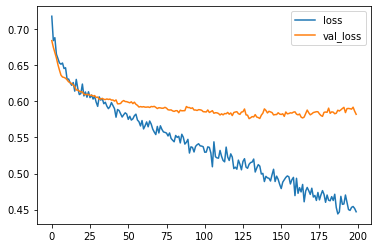

In [94]:
# 劃出 model.fit() training 和 validating 的 loss
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

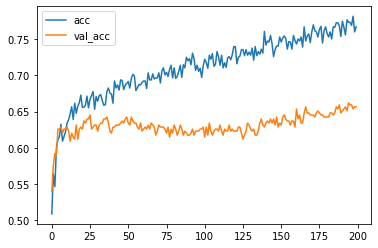

In [95]:
# 劃出準確性 accuracy 
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [18]:
pred_test = model.predict(X_test)
pred_test = np.round(pred_test).flatten()
cm = confusion_matrix(y_test, pred_test)
cm

array([[136,  43],
       [ 28, 151]], dtype=int64)

<h1> 4-2 以羅吉斯回歸實作 - 預測毛利率

In [96]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression()
log.fit(X_train, y_train)

log_pred = log.predict(X_test)
print(log_pred)
print("==============================")
print(log.score(X_train, y_train))
# print(y_test)

[1 0 0 0 1 0 0 0 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1
 0 1 0 0 0 0 0 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 0 0 1 0 1 1 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 1 0 1 0 1 1 1 0 1 1
 1 0 1 1 1 0 1 0 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 0 1 0 1 0 0 1 0 0 1
 0 1 1 0 1 0 1 0 1 0 1 1 1 0 0 1 1 0 0 0 1 1 0 0 1 1 0 1 1 0 0 1 1 0 0 1 0
 0 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1
 0 0 1 1 1 0 1 0 0 0 0 0 0 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 0 1 0 1 1
 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 0 0 0 0 0 1 1 0
 1 0 0 0 1 1 0 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 1 1 1 1 1 1
 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 0 0 0]
0.6951048951048951


In [97]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, log_pred)
accuracy

0.6312849162011173

In [98]:
cm = confusion_matrix(y_test, log_pred)
cm

array([[101,  73],
       [ 59, 125]], dtype=int64)

<h2> 4-3 以 SVM 實作 - 預測毛利率

In [ ]:
from sklearn.svm import SVC
clf = SVC(C = 1e5, kernel = 'linear')
clf.fit(X_train, y_train) 

In [ ]:
pred_clf = clf.predict(X_test)
print(pred_clf)
print("==============================")
print(clf.score(X_train, y_train))

In [ ]:
accuracy_SVM = accuracy_score(y_test, pred_clf)
accuracy_SVM

<h1>4.4 以 RandomForestClassifier 實作 毛利率預測

In [99]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
forest=RandomForestClassifier(n_estimators=100)


#Train the model using the training sets y_pred=clf.predict(X_test)
forest.fit(X_train, y_train)
print(forest.score(X_train, y_train))

1.0


In [100]:
from sklearn.metrics import accuracy_score
forest_pred=forest.predict(X_test)
print("Accuracy:",accuracy_score(y_test, forest_pred))

Accuracy: 0.8212290502793296


In [101]:
pred_test = np.round(forest_pred).flatten()
cm = confusion_matrix(y_test, pred_test)
cm

array([[142,  32],
       [ 32, 152]], dtype=int64)

<h1> 4.5 以 naive_bayes 實作 毛利率預測

In [102]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)
print(nb.score(X_train, y_train))

0.6307692307692307


In [103]:
nb_pred = nb.predict(X_test)
print("Accuracy:",accuracy_score(y_test, nb_pred))

Accuracy: 0.6284916201117319


In [104]:
pred_test = np.round(nb_pred).flatten()
cm = confusion_matrix(y_test, pred_test)
cm

array([[121,  53],
       [ 80, 104]], dtype=int64)

<h1> 4.6 以 KNN 實作 毛利率預測

In [105]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print(knn.score(X_train, y_train))

0.7195804195804196


In [106]:
knn_pred = knn.predict(X_test)
print("Accuracy:",accuracy_score(y_test, knn_pred))

Accuracy: 0.5949720670391061


In [107]:
pred_test = np.round(knn_pred).flatten()
cm = confusion_matrix(y_test, pred_test)
cm

array([[ 92,  82],
       [ 63, 121]], dtype=int64)

<h2> 5-1 以 DNN 實作預測 淨利率

In [108]:
X_train, X_test, y1_train, y1_test = train_test_split(X_scaled, y1, test_size=0.2)
N, D = X_train.shape
print ("N:", N, "D:", D)

N: 1430 D: 28


In [109]:
# 建立TF模型 for 淨利
model1 = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(D,)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
  ])

#編譯模型
lr = 0.0003
model1.compile(tf.keras.optimizers.Adam(learning_rate = lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [110]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                1856      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 3,969
Trainable params: 3,969
Non-trainable params: 0
_________________________________________________________________


In [111]:
# 訓練模型
r1 = model1.fit(X_train, y1_train, validation_data=(X_test, y1_test), epochs=120)

# 評估模型 - evaluate() returns loss and accuracy
print("Train score:", model1.evaluate(X_train, y1_train))
print("Test score:", model1.evaluate(X_test, y1_test))

Epoch 1/120
45/45 [==============================] - 1s 4ms/step - loss: 0.7189 - accuracy: 0.5350 - val_loss: 0.6128 - val_accuracy: 0.6732
Epoch 2/120
45/45 [==============================] - 0s 1ms/step - loss: 0.6227 - accuracy: 0.6720 - val_loss: 0.5761 - val_accuracy: 0.7011
Epoch 3/120
45/45 [==============================] - 0s 1ms/step - loss: 0.6030 - accuracy: 0.6762 - val_loss: 0.5582 - val_accuracy: 0.7039
Epoch 4/120
45/45 [==============================] - 0s 1ms/step - loss: 0.5769 - accuracy: 0.7007 - val_loss: 0.5458 - val_accuracy: 0.7011
Epoch 5/120
45/45 [==============================] - 0s 1ms/step - loss: 0.5741 - accuracy: 0.7105 - val_loss: 0.5345 - val_accuracy: 0.7179
Epoch 6/120
45/45 [==============================] - 0s 1ms/step - loss: 0.5555 - accuracy: 0.7161 - val_loss: 0.5248 - val_accuracy: 0.7235
Epoch 7/120
45/45 [==============================] - 0s 1ms/step - loss: 0.5399 - accuracy: 0.7224 - val_loss: 0.5176 - val_accuracy: 0.7291
Epoch 8/120
4

Epoch 59/120
45/45 [==============================] - 0s 1ms/step - loss: 0.4472 - accuracy: 0.7958 - val_loss: 0.4568 - val_accuracy: 0.8017
Epoch 60/120
45/45 [==============================] - 0s 1ms/step - loss: 0.4386 - accuracy: 0.7916 - val_loss: 0.4582 - val_accuracy: 0.7989
Epoch 61/120
45/45 [==============================] - 0s 1ms/step - loss: 0.4426 - accuracy: 0.7944 - val_loss: 0.4572 - val_accuracy: 0.7961
Epoch 62/120
45/45 [==============================] - 0s 1ms/step - loss: 0.4402 - accuracy: 0.8014 - val_loss: 0.4581 - val_accuracy: 0.7989
Epoch 63/120
45/45 [==============================] - 0s 1ms/step - loss: 0.4422 - accuracy: 0.7937 - val_loss: 0.4592 - val_accuracy: 0.7933
Epoch 64/120
45/45 [==============================] - 0s 1ms/step - loss: 0.4331 - accuracy: 0.7993 - val_loss: 0.4601 - val_accuracy: 0.8017
Epoch 65/120
45/45 [==============================] - 0s 1ms/step - loss: 0.4334 - accuracy: 0.7930 - val_loss: 0.4599 - val_accuracy: 0.7989
Epoch 

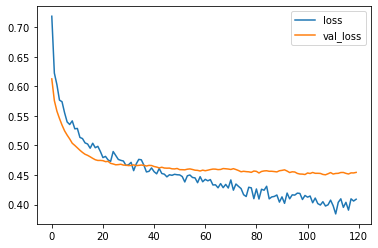

In [112]:
# 劃出 model.fit() training 和 validating 的 loss
import matplotlib.pyplot as plt
plt.plot(r1.history['loss'], label='loss')
plt.plot(r1.history['val_loss'], label='val_loss')
plt.legend()

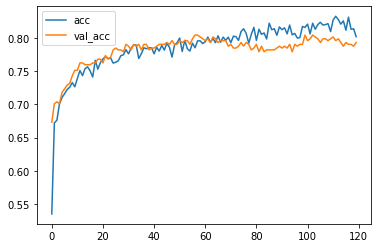

In [113]:
# 劃出準確性 accuracy 
plt.plot(r1.history['accuracy'], label='acc')
plt.plot(r1.history['val_accuracy'], label='val_acc')
plt.legend()

In [114]:
model.save('./net_profit_model.h5')

<h1> 5-2 用羅吉斯回歸實作 預測淨利率

In [115]:
from sklearn.linear_model import LogisticRegression
log1 = LogisticRegression()
log1.fit(X_train, y1_train)

pred1 = log1.predict(X_test)
print(pred1)
print("==============================")
print(log1.score(X_train, y1_train))
# print(y_test)

[1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 0 0 1 0 0 1 0 1 0 0 1 1 1 0
 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0
 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0
 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1 1 0 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0
 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0]
0.7706293706293706


In [116]:
accuracy1 = accuracy_score(y1_test, pred1)
accuracy1

0.776536312849162

<h1> 5-3 以 SVM 實作 預測淨利率

In [ ]:
from sklearn.svm import SVC
clf1 = SVC(C = 1e5, kernel = 'linear')
clf1.fit(X_train, y1_train) 
pred_clf1 = clf1.predict(X_test)
print(pred_clf1)
print("==============================")
print(clf1.score(X_train, y1_train))

In [ ]:
accuracy_SVM = accuracy_score(y1_test, pred_clf1)
accuracy_SVM

<h1>5-4 以 RandomForestClassifier 實作 淨利率 預測

In [117]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
forest1=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
forest1.fit(X_train, y1_train)
print(forest1.score(X_train, y1_train))

1.0


In [118]:
from sklearn.metrics import accuracy_score
forest_pred1=forest1.predict(X_test)
print("Accuracy:",accuracy_score(y1_test, forest_pred1))

Accuracy: 0.8184357541899442


<h1> 5-5 以 naive_bayes 實作 淨利率 預測

In [119]:
from sklearn.naive_bayes import GaussianNB
nb1 = GaussianNB()
nb1.fit(X_train, y1_train)
print(nb1.score(X_train, y1_train))

0.7461538461538462


In [120]:
nb1_pred = nb1.predict(X_test)
print("Accuracy:",accuracy_score(y1_test, nb1_pred))

Accuracy: 0.7458100558659218


<h1> 5-6 以 KNN 實作 淨利率 預測

In [121]:
from sklearn.neighbors import KNeighborsClassifier
knn1 = KNeighborsClassifier()
knn1.fit(X_train, y1_train)
print(knn1.score(X_train, y1_train))

0.8272727272727273


In [122]:
knn1_pred = knn1.predict(X_test)
print("Accuracy:",accuracy_score(y1_test, knn1_pred))

Accuracy: 0.7150837988826816


In [60]:
X1_scaled = pd.DataFrame()
a, b = X1.shape

for i in range(b):
    x1_new = mean_norm(X1[X1.columns[i]])
    X1_scaled.insert(i,X1.columns[i],x1_new)
X1_scaled

,current_rate,quick_rate,debt_rate,operating_gross_rate,receivables_turnover_rate,cash_reinvest_rate,avg_director_rate,avg_director_pledge_rate,foreign_rate_bys,over1000_rate_bys,under400_rate_bys,avg_board_bys,avg_import_rate
0,-0.497595,-0.459666,-0.824804,0.293646,-0.159355,-0.233499,0.437739,-0.405628,-0.643864,0.842469,-0.637059,-0.298683,0.653842
1,-0.468749,-0.443455,-0.904884,0.406062,-0.060091,-0.268016,0.437739,-0.405628,-0.643864,0.848042,-0.632518,-0.289146,0.825146
2,-0.457062,-0.444712,-0.933148,0.254882,-0.380792,-0.253346,0.437739,-0.405628,-0.645352,0.856400,-0.652700,-0.286212,0.805381
3,-0.450589,-0.432874,-0.918427,0.063776,-0.284391,-0.196393,0.437739,-0.405628,-0.648822,0.847577,-0.661277,-0.278142,1.094339
4,-0.461485,-0.427728,-0.870144,-0.064920,-0.179399,-0.010865,0.437739,-0.405628,-0.648822,0.847113,-0.664809,-0.270806,1.151754
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1783,-0.160125,-0.271150,-0.264240,-0.220751,-0.066772,0.176390,-0.080402,0.701591,1.672838,-0.113698,-0.093660,-0.388184,-0.078436
1784,-0.009934,-0.128851,-0.504482,-0.304094,0.116486,0.069387,-0.049547,1.151263,1.395210,-0.318027,0.255488,-0.456411,-0.494460
1785,-0.118567,-0.154049,-0.361397,-0.287038,0.299745,0.589730,-0.039650,1.142565,1.471558,-0.344497,0.222692,-0.440271,-1.168382
1786,-0.201031,-0.246508,-0.171205,-0.028870,-0.289163,-0.702930,-0.039650,1.142565,1.545922,-0.256728,0.045091,-0.438804,-1.510991


In [61]:
#分割資料為 測試集 與 訓練集
from sklearn.model_selection import train_test_split
X1_train, X1_test, y2_train, y2_test = train_test_split(X1_scaled, y2, test_size=0.2,random_state=1)
N, D = X1_train.shape
print ("N:", N, "D:", D)

N: 1430 D: 13


<h2> 6-1 以 DNN 實作預測 ROE

In [62]:
# 建立TF模型 for 淨利
model3 = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(D,)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
  ])

#編譯模型
lr = 0.0003
model3.compile(tf.keras.optimizers.Adam(learning_rate = lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [63]:
model3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 64)                896       
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 33        
Total params: 3,009
Trainable params: 3,009
Non-trainable params: 0
_________________________________________________________________


In [64]:
# 訓練模型
r3 = model3.fit(X1_train, y2_train, validation_data=(X1_test, y2_test), epochs=150)

# 評估模型 - evaluate() returns loss and accuracy
print("Train score:", model3.evaluate(X1_train, y2_train))
print("Test score:", model3.evaluate(X1_test, y2_test))

Epoch 1/150
45/45 [==============================] - 0s 3ms/step - loss: 0.6821 - accuracy: 0.5797 - val_loss: 0.6290 - val_accuracy: 0.6927
Epoch 2/150
45/45 [==============================] - 0s 1ms/step - loss: 0.6403 - accuracy: 0.6378 - val_loss: 0.6028 - val_accuracy: 0.7235
Epoch 3/150
45/45 [==============================] - 0s 1ms/step - loss: 0.6179 - accuracy: 0.6615 - val_loss: 0.5806 - val_accuracy: 0.7207
Epoch 4/150
45/45 [==============================] - 0s 1ms/step - loss: 0.5995 - accuracy: 0.6874 - val_loss: 0.5630 - val_accuracy: 0.7346
Epoch 5/150
45/45 [==============================] - 0s 1ms/step - loss: 0.5903 - accuracy: 0.6881 - val_loss: 0.5488 - val_accuracy: 0.7458
Epoch 6/150
45/45 [==============================] - 0s 1ms/step - loss: 0.5685 - accuracy: 0.7105 - val_loss: 0.5353 - val_accuracy: 0.7598
Epoch 7/150
45/45 [==============================] - 0s 1ms/step - loss: 0.5476 - accuracy: 0.7301 - val_loss: 0.5236 - val_accuracy: 0.7654
Epoch 8/150
4

Epoch 59/150
45/45 [==============================] - 0s 1ms/step - loss: 0.4319 - accuracy: 0.8070 - val_loss: 0.4442 - val_accuracy: 0.7877
Epoch 60/150
45/45 [==============================] - 0s 1ms/step - loss: 0.4388 - accuracy: 0.7930 - val_loss: 0.4451 - val_accuracy: 0.7793
Epoch 61/150
45/45 [==============================] - 0s 1ms/step - loss: 0.4271 - accuracy: 0.8126 - val_loss: 0.4451 - val_accuracy: 0.7849
Epoch 62/150
45/45 [==============================] - 0s 1ms/step - loss: 0.4376 - accuracy: 0.7965 - val_loss: 0.4452 - val_accuracy: 0.7821
Epoch 63/150
45/45 [==============================] - 0s 1ms/step - loss: 0.4423 - accuracy: 0.7916 - val_loss: 0.4450 - val_accuracy: 0.7849
Epoch 64/150
45/45 [==============================] - 0s 1ms/step - loss: 0.4252 - accuracy: 0.8126 - val_loss: 0.4435 - val_accuracy: 0.7765
Epoch 65/150
45/45 [==============================] - 0s 1ms/step - loss: 0.4353 - accuracy: 0.7916 - val_loss: 0.4431 - val_accuracy: 0.7821
Epoch 

45/45 [==============================] - 0s 1ms/step - loss: 0.3938 - accuracy: 0.8175 - val_loss: 0.4358 - val_accuracy: 0.8017
Epoch 117/150
45/45 [==============================] - 0s 1ms/step - loss: 0.3921 - accuracy: 0.8252 - val_loss: 0.4357 - val_accuracy: 0.8045
Epoch 118/150
45/45 [==============================] - 0s 1ms/step - loss: 0.3849 - accuracy: 0.8294 - val_loss: 0.4367 - val_accuracy: 0.8017
Epoch 119/150
45/45 [==============================] - 0s 1ms/step - loss: 0.4008 - accuracy: 0.8231 - val_loss: 0.4341 - val_accuracy: 0.7905
Epoch 120/150
45/45 [==============================] - 0s 1ms/step - loss: 0.3833 - accuracy: 0.8315 - val_loss: 0.4341 - val_accuracy: 0.7933
Epoch 121/150
45/45 [==============================] - 0s 1ms/step - loss: 0.4060 - accuracy: 0.8210 - val_loss: 0.4351 - val_accuracy: 0.7905
Epoch 122/150
45/45 [==============================] - 0s 1ms/step - loss: 0.3914 - accuracy: 0.8336 - val_loss: 0.4363 - val_accuracy: 0.7905
Epoch 123/150

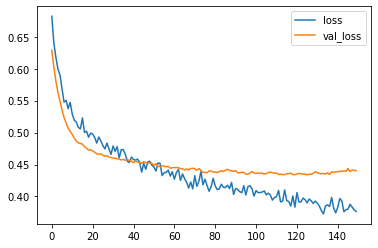

In [65]:
# 劃出 model.fit() training 和 validating 的 loss
import matplotlib.pyplot as plt
plt.plot(r3.history['loss'], label='loss')
plt.plot(r3.history['val_loss'], label='val_loss')
plt.legend()

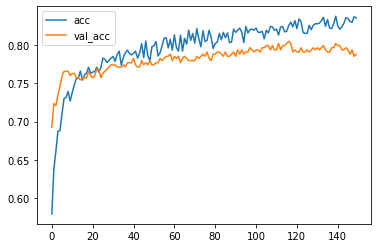

In [66]:
# 劃出準確性 accuracy 
plt.plot(r3.history['accuracy'], label='acc')
plt.plot(r3.history['val_accuracy'], label='val_acc')
plt.legend()

In [67]:
pred_test = model3.predict(X1_test)
pred_test = np.round(pred_test).flatten()
cm = confusion_matrix(y2_test, pred_test)
cm

array([[128,  45],
       [ 31, 154]], dtype=int64)

In [58]:
model3.save('./ROE_model.h5')

<h1> 6-2 用羅吉斯回歸實作 預測 ROE

In [133]:
from sklearn.linear_model import LogisticRegression
log3 = LogisticRegression()
log3.fit(X1_train, y2_train)

pred3 = log3.predict(X1_test)
print(pred3)
print("==============================")
print(log3.score(X1_train, y2_train))
# print(y_test)

[0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 1 1 0 1 1 0 0 0 1 0 1 0 0 0
 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1
 0 1 1 1 1 0 0 0 0 1 1 0 1 1 1 0 1 0 1 0 0 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 0
 1 1 0 1 1 1 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0 1 0 1 1
 0 0 1 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1 1
 0 0 1 0 1 1 1 0 1 1 1 0 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 1 1 0 1 1 1 1 0 0
 0 0 1 1 1 1 0 1 0 0 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1
 0 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0 0 0 0 1 0 1 0 1 1 1 1 1
 1 1 1 1 1 0 0 0 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 1]
0.7622377622377622


In [134]:
accuracy3 = accuracy_score(y2_test, pred3)
accuracy3

0.7625698324022346

<h1> 6-3 以 SVM 實作 預測 ROE

In [ ]:
from sklearn.svm import SVC
clf3 = SVC(C = 1e5, kernel = 'linear')
clf3.fit(X1_train, y2_train) 
pred_clf3 = clf3.predict(X1_test)
print(pred_clf3)
print("==============================")
print(clf3.score(X1_train, y2_train))

In [ ]:
accuracy_SVM = accuracy_score(y2_test, pred_clf3)
accuracy_SVM

<h1>6.4 以 RandomForestClassifier 實作 ROE 預測

In [135]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
forest3=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
forest3.fit(X1_train, y2_train)
print(forest3.score(X1_train, y2_train))

1.0


In [136]:
from sklearn.metrics import accuracy_score
forest_pred3 = forest3.predict(X1_test)
print("Accuracy:",accuracy_score(y2_test, forest_pred3))

Accuracy: 0.8016759776536313


<h1> 6.5 以 naive_bayes 實作 ROE 預測

In [137]:
from sklearn.naive_bayes import GaussianNB
nb3 = GaussianNB()
nb3.fit(X1_train, y2_train)
print(nb3.score(X1_train, y2_train))

0.6986013986013986


In [138]:
nb3_pred = nb3.predict(X1_test)
print("Accuracy:",accuracy_score(y2_test, nb3_pred))

Accuracy: 0.6815642458100558


<h1> 6.6 以 KNN 實作 ROE 預測

In [139]:
from sklearn.neighbors import KNeighborsClassifier
knn3 = KNeighborsClassifier()
knn3.fit(X1_train, y2_train)
print(knn3.score(X1_train, y2_train))

0.7909090909090909


In [140]:
knn3_pred = knn3.predict(X1_test)
print("Accuracy:",accuracy_score(y2_test, knn3_pred))

Accuracy: 0.7206703910614525
